<a href="https://colab.research.google.com/github/plaban1981/Dphi_hackathon/blob/main/Data_Sprint_38_The_Kvasir_Capsule_Dataset_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Problem Statement
 
Artificial intelligence (AI) is predicted to have profound effects on the future of video capsule endoscopy (VCE) technology.The potential lies in improving anomaly detection while reducing manual labour. However, medical data is often sparse and unavailable to the research community, and qualified medical personnel rarely have time for the tedious labelling work.

## Objective
 

You are required to build a machine learning model to recognize the disease label of the respective images.

## Content
 

The small bowel constitutes the gastrointestinal (GI) tract’s mid-part, situated between the stomach and the large bowel. It is three to four meters long and has a surface of about 30 m^2, including the surface of the villi, and plays a crucial role in absorbing nutrients. Therefore, disorders in the small bowel may cause severe growth retardation in children and nutrient deﬁciencies in children and adults. 

This organ may be affected by 
**chronic diseases**, like 
* Crohn’s disease, 
* coeliac disease, and 
* angiectasis

or  **malignant diseases** like 
* lymphoma and 
* adenocarcinoma. 

These diseases may represent a substantial health challenge for both patients and society, and a thorough examination of the lumen is frequently necessary to diagnose and treat them. However, the small bowel, due to its anatomical location, is less accessible for inspection by ﬂexible endoscopes commonly used for the upper GI tract and the large bowel. Since early 2000, video capsule endoscopy (VCE) has been used, usually as a complementary test for patients with GI bleeding. 

A VCE consists of a small capsule containing a wide-angle camera, lightsources, batteries, and other electronics. The patient swallows the capsule, which then captures a video as it moves passively through the GI tract. A recorder, carried by the patient or included in the capsule, stores the video before a medical expert assesses it after the procedure. 

[Source of information: Reasearch paper: Kvasir-Capsule, a video capsule endoscopy dataset]

## Mount Drive

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


## Download the images

In [ ]:
from google_drive_downloader import GoogleDriveDownloader as gdd

gdd.download_file_from_google_drive(file_id='1yDcNMTI-8Zq2Mvs8qe7pLNpPx4BW5Yta',
dest_path='/content/drive/MyDrive/dphi/Kvasir/The Kvasir-Capsule.zip',unzip=True)

Unzipping...Done.


## Import Data Science packages

In [2]:
#changing filename to paths
import os
import pandas as pd
import numpy as np
import PIL
import cv2
#
import seaborn as sns
import matplotlib.pyplot as plt
#
import warnings
warnings.filterwarnings("ignore")
#
%matplotlib inline

## Import Data

In [66]:
train_data = pd.read_csv("/content/drive/MyDrive/dphi/Kvasir/The Kvasir-Capsule/Training_set.csv")
test_data = pd.read_csv("/content/drive/MyDrive/dphi/Kvasir/The Kvasir-Capsule/Testing_set.csv")

In [4]:
train_data.head()

,filename,label
0,Image_1.jpg,Normal clean mucosa
1,Image_2.jpg,Normal clean mucosa
2,Image_3.jpg,Foreign body
3,Image_4.jpg,Normal clean mucosa
4,Image_5.jpg,Normal clean mucosa


In [ ]:
train_data.shape

(37790, 2)

In [ ]:
test_data.head()

,filename
0,Image_1.jpg
1,Image_2.jpg
2,Image_3.jpg
3,Image_4.jpg
4,Image_5.jpg


In [ ]:
test_data.shape

(9448, 1)

## Unique Labels

In [ ]:
labels = train_data['label'].unique().tolist()
labels

['Normal clean mucosa',
 'Foreign body',
 'Reduced mucosal view',
 'Ileocecal valve',
 'Lymphangiectasia',
 'ulcer',
 'Angiectasia',
 'Pylorus',
 'Erosion',
 'Blood - fresh',
 'Erythema',
 'Polyp',
 'ampulla_of_vater',
 'Blood - hematin']

## Add the complete path for the training images

In [67]:
paths = [os.path.join("/content/drive/MyDrive/dphi/Kvasir/The Kvasir-Capsule/train", x) for x in train_data['filename']]
test_paths = [os.path.join("/content/drive/MyDrive/dphi/Kvasir/The Kvasir-Capsule/test", x) for x in test_data['filename']]

In [68]:
train_data['image_path'] = paths
test_data['image_path'] = test_paths

train_data.drop(['filename'], axis = 1, inplace=True)
test_data.drop(['filename'], axis = 1, inplace=True)

In [69]:
file_paths = train_data.image_path.values.tolist()
labels = train_data.label.values.tolist()

In [70]:
train_data.head()

,label,image_path
0,Normal clean mucosa,/content/drive/MyDrive/dphi/Kvasir/The Kvasir-...
1,Normal clean mucosa,/content/drive/MyDrive/dphi/Kvasir/The Kvasir-...
2,Foreign body,/content/drive/MyDrive/dphi/Kvasir/The Kvasir-...
3,Normal clean mucosa,/content/drive/MyDrive/dphi/Kvasir/The Kvasir-...
4,Normal clean mucosa,/content/drive/MyDrive/dphi/Kvasir/The Kvasir-...


In [71]:
train_data = train_data[['image_path','label']]
train_data.head()

,image_path,label
0,/content/drive/MyDrive/dphi/Kvasir/The Kvasir-...,Normal clean mucosa
1,/content/drive/MyDrive/dphi/Kvasir/The Kvasir-...,Normal clean mucosa
2,/content/drive/MyDrive/dphi/Kvasir/The Kvasir-...,Foreign body
3,/content/drive/MyDrive/dphi/Kvasir/The Kvasir-...,Normal clean mucosa
4,/content/drive/MyDrive/dphi/Kvasir/The Kvasir-...,Normal clean mucosa


In [72]:
test_data.head()

,image_path
0,/content/drive/MyDrive/dphi/Kvasir/The Kvasir-...
1,/content/drive/MyDrive/dphi/Kvasir/The Kvasir-...
2,/content/drive/MyDrive/dphi/Kvasir/The Kvasir-...
3,/content/drive/MyDrive/dphi/Kvasir/The Kvasir-...
4,/content/drive/MyDrive/dphi/Kvasir/The Kvasir-...


## Function to preproces images

In [12]:
def preProcess_Image(image):
  img = cv2.imread(image)
  img = cv2.resize(img, (229, 229))
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img = cv2.addWeighted (img, 4, cv2.GaussianBlur(img, (0,0), 512/10), -4, 128)
  img = cv2.equalizeHist(img[:, :, 0])
  #img = cv2.Canny(img, 80, 100)
  #kernel = np.ones((5, 5), np.uint8)
  #img = cv2.erode(img, kernel, iterations=3)
  return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

## Function to display the images

In [13]:
def show_image(image,label):
  f, (ax1, ax2) = plt.subplots(1, 2, sharey=True,figsize=(12,10))
  orig_img = cv2.imread(image)
  orig_img = cv2.resize(orig_img, (229, 229))
  processed_img =  preProcess_Image(image)
  ax1.imshow(orig_img)
  ax2.imshow(processed_img)
  ax1.set_title(f'Original Image {label}')
  ax2.set_title(f'Processed Image {label}')

##Shape of the images after preprocessing

In [14]:
file_paths = train_data.image_path.values.tolist()

In [15]:
preProcess_Image(file_paths[0]).shape

(229, 229, 3)

## Display Random  Training Images

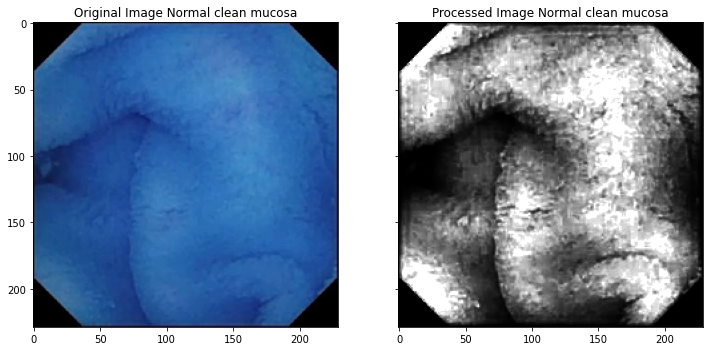

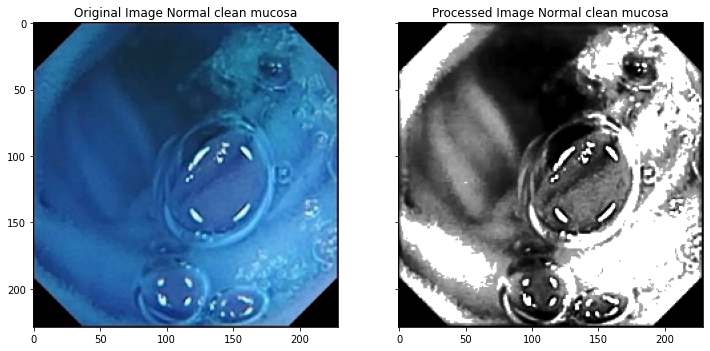

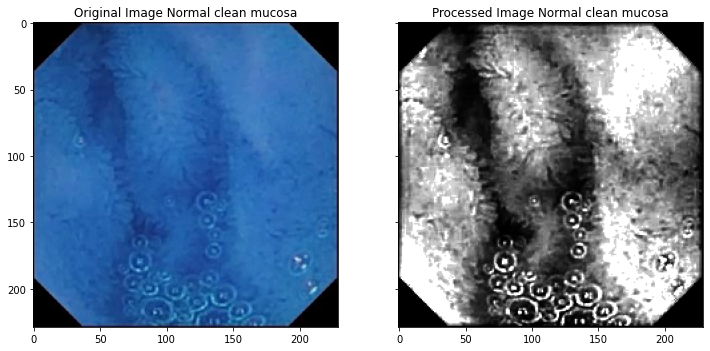

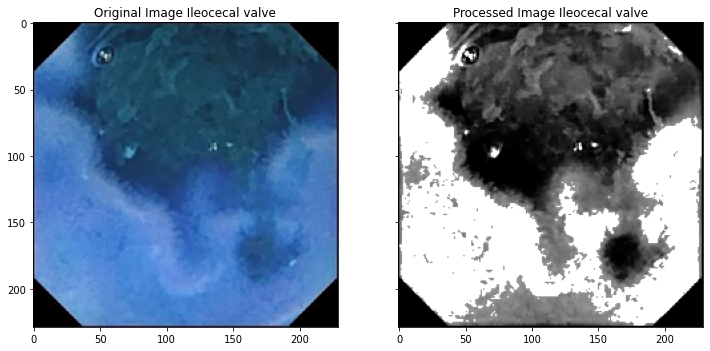

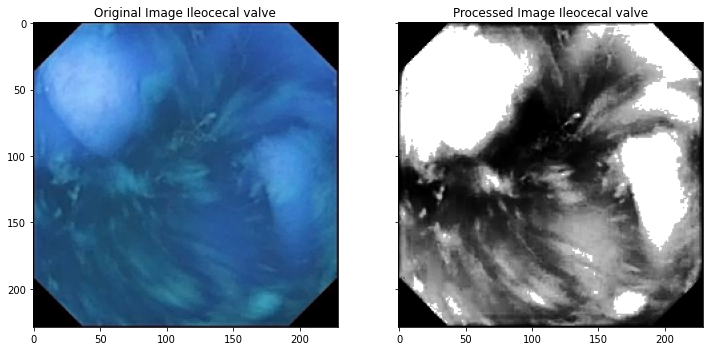

In [16]:
for i in range(5):
  i = np.random.randint(1000,2000)
  show_image(file_paths[i],labels[i])

## Visualize Test Images

In [18]:
def show_test_image(image):
  f, (ax1, ax2) = plt.subplots(1, 2, sharey=True,figsize=(12,10))
  orig_img = cv2.imread(image)
  orig_img = cv2.resize(orig_img, (229, 229))
  processed_img =  preProcess_Image(image)
  ax1.imshow(orig_img)
  ax2.imshow(processed_img)
  ax1.set_title(f'Original Test Image')
  ax2.set_title(f'Processed Test Image')

In [19]:
test_images = test_data.image_path.values.tolist()

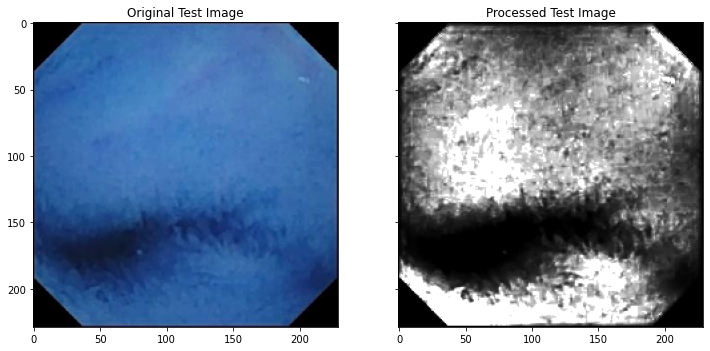

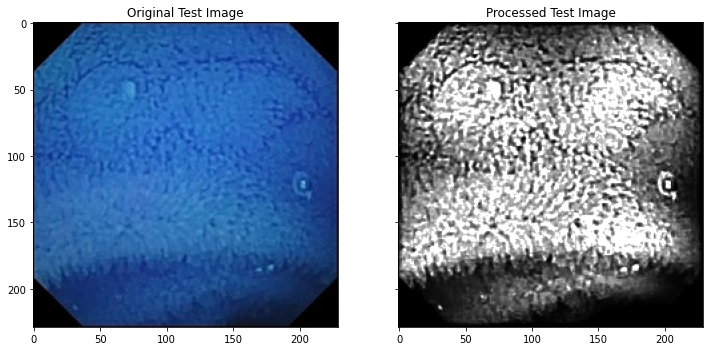

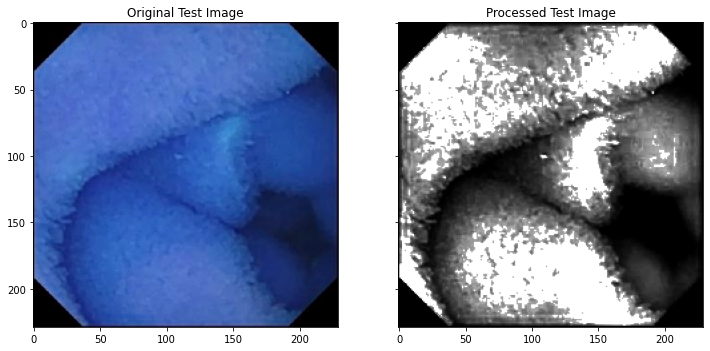

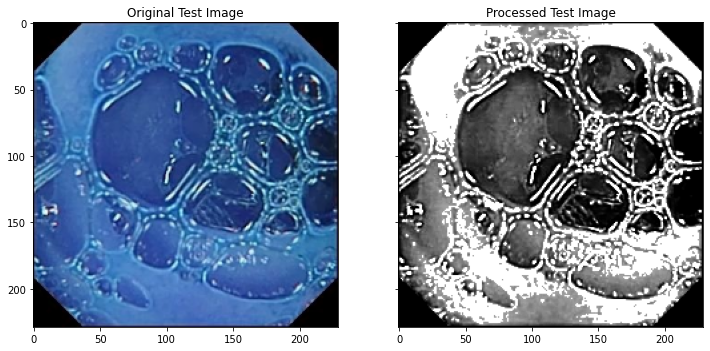

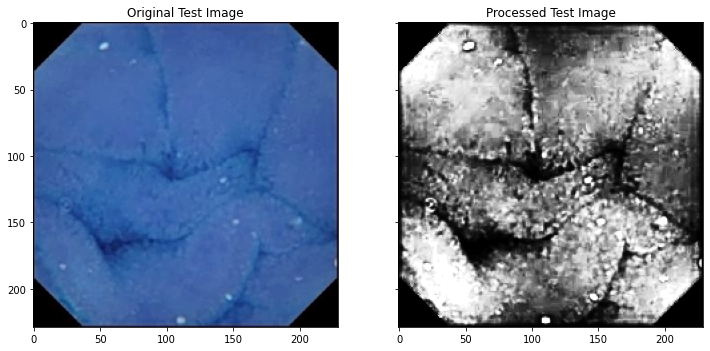

In [20]:
for i in range(5):
  i = np.random.randint(1000,2000)
  show_test_image(test_images[i])

## Distribution of labels

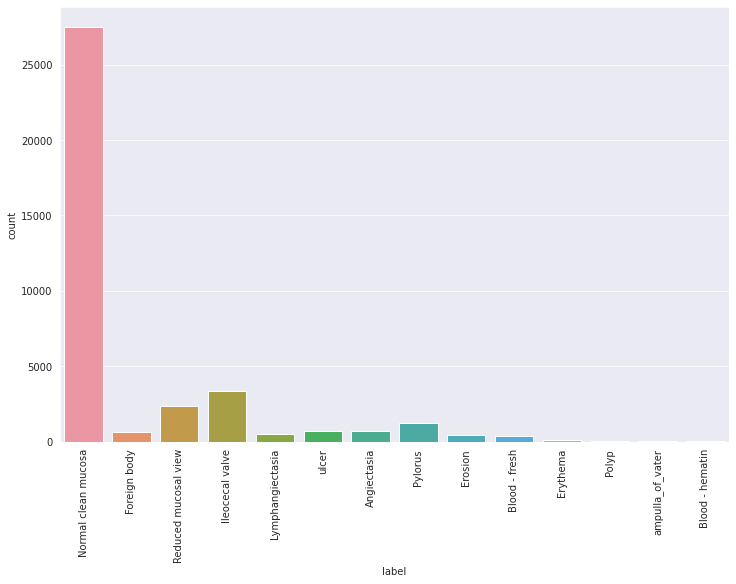

In [ ]:
sns.set_style('darkgrid')
plt.figure(figsize=(12,8))
plt.xticks(rotation =90)
sns.countplot(train_data.label)

## Count of each label

In [ ]:
train_data.label.value_counts()

Normal clean mucosa     27470
Ileocecal valve          3351
Reduced mucosal view     2325
Pylorus                  1223
Angiectasia               693
ulcer                     683
Foreign body              621
Lymphangiectasia          473
Erosion                   405
Blood - fresh             357
Erythema                  127
Polyp                      44
Blood - hematin            10
ampulla_of_vater            8
Name: label, dtype: int64

## Make Folders for each images

In [ ]:
Root = "/content/drive/MyDrive/dphi/Kvasir/The Kvasir-Capsule/"
new_folder = "TRAIN"
val_folder = "VAL"
_dir = os.path.join(Root,val_folder)

In [ ]:
_dir

'/content/drive/MyDrive/dphi/Kvasir/The Kvasir-Capsule/VAL'

In [ ]:
os.path.exists(_dir)

False

In [ ]:
if not os.path.exists(_dir):
    os.makedirs(_dir)

In [ ]:
target_folders = ['TRAIN','VAL']

In [ ]:
for f in target_folders:
  for label in labels:
    _dir = os.path.join(Root,f,label)
    if not os.path.exists(_dir):
      os.makedirs(_dir)

##Check if certain .jpg files are empty


In [73]:
import tqdm
import os
img_list  = train_data.image_path.values.tolist()
empty_images = []
empty_index = []
for i,img in tqdm.tqdm(enumerate(img_list)):
  if os.stat(img).st_size == 0:
    try:
      empty_images.append(img)
      empty_index.append(i)
    except:
      pass

37790it [00:07, 5119.84it/s]


In [74]:
len(empty_images)

14

In [23]:
train_data.shape

(37790, 2)

In [75]:
train_data = train_data[~train_data['image_path'].isin(empty_images)]

In [76]:
train_data.shape

(37776, 2)

## Copy Training images to respective folders

In [ ]:
import shutil
from tqdm import tqdm
for data in tqdm(train_data.values.tolist()):
  images = data[0]
  lbls = data[1]
  dest = os.path.join(Root,'TRAIN',lbls)
  if os.stat(images).st_size != 0:
    shutil.copy(images,dest)


100%|██████████| 37790/37790 [5:04:43<00:00,  2.07it/s]


## Copy Validation data into respective folders

In [ ]:
import shutil
from tqdm import tqdm
for data in tqdm(val_set.values.tolist()):
  images = data[0]
  lbls = data[1]
  dest = os.path.join(Root,'VAL',lbls)
  if os.stat(images).st_size != 0:
    shutil.copy(images,dest)

## Label Mapping

In [57]:
def f(r):
  if r == "ampulla_of_vater":
    return 0
  elif r == "Angiectasia":
    return 1
  elif r == "Blood - fresh":
    return 2
  elif r == "Blood - hematin":
    return 3
  elif r == "Erosion":
    return 4
  elif r == "Erythema":
    return 5
  elif r == "Foreign body":
    return 6
  elif r == "Ileocecal valve":
    return 7
  elif r == "Lymphangiectasia":
    return 8
  elif r == "Normal clean mucosa":
    return 9
  elif r == "Polyp":
    return 10
  elif r == "Pylorus":
    return 11
  elif r == "Reduced mucosal view":
    return 12
  else:
    return 13

In [58]:
train_data['label'] = train_data['label'].apply(f)

In [77]:
train_data.head()

,image_path,label
0,/content/drive/MyDrive/dphi/Kvasir/The Kvasir-...,Normal clean mucosa
1,/content/drive/MyDrive/dphi/Kvasir/The Kvasir-...,Normal clean mucosa
2,/content/drive/MyDrive/dphi/Kvasir/The Kvasir-...,Foreign body
3,/content/drive/MyDrive/dphi/Kvasir/The Kvasir-...,Normal clean mucosa
4,/content/drive/MyDrive/dphi/Kvasir/The Kvasir-...,Normal clean mucosa


## Apply Startified kfolds to handle imbalanced dataset

In [64]:
from sklearn.model_selection import KFold, StratifiedKFold
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.layers import Dense, Dropout,  Conv2D, Input, Lambda, Flatten, TimeDistributed, Activation, MaxPool2D
from tensorflow.keras.layers import Add, Reshape, MaxPooling2D, Concatenate, Embedding, RepeatVector, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.regularizers import *
#
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import seaborn as sns
sns.set_style('darkgrid')
#
import os
import shutil
import cv2
import glob
from tqdm.notebook import tqdm
from tqdm import tqdm
from PIL import Image
#
import gc
#
import warnings
warnings.filterwarnings('ignore')

In [29]:
Y = train_data[['label']]
kf = KFold(n_splits = 5)                       
skf = StratifiedKFold(n_splits = 5, random_state = 7, shuffle = True) 

## Create an instance of the ImageDataGenerator class

In [80]:
batch_size=32
image_shape=(229,229,3)
class_mode='categorical'

In [79]:
generator = ImageDataGenerator(rescale=1./255)

## Auxiliary function for getting model name in each of the k iterations

In [81]:
def get_model_name(k):
    return 'model_'+str(k)+'.h5'

## Define a function to claibrate F1 Scores

In [82]:
import keras.backend as K

In [83]:
def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

## Create Model

In [86]:
def create_model():
  model = Sequential()

  conv_base = tf.keras.applications.DenseNet121(input_shape=(229,229,3), include_top=False, pooling='max',weights='imagenet')
  model.add(conv_base)
  model.add(BatchNormalization())
  model.add(Dense(2048, activation='relu', kernel_regularizer=l1_l2(0.01)))
  model.add(BatchNormalization())
  model.add(Dense(14, activation='softmax'))

  train_layers = [layer for layer in conv_base.layers[::-1][:5]]

  for layer in conv_base.layers:
    if layer in train_layers:
      layer.trainable = True
  return model
  

In [65]:
 create_model().summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Functional)     (None, 1920)              18321984  
_________________________________________________________________
batch_normalization_105 (Bat (None, 1920)              7680      
_________________________________________________________________
dense_83 (Dense)             (None, 2048)              3934208   
_________________________________________________________________
batch_normalization_106 (Bat (None, 2048)              8192      
_________________________________________________________________
dense_84 (Dense)             (None, 14)                28686     
Total params: 22,300,750
Trainable params: 22,063,758
Non-trainable params: 236,992
_________________________________________________________________


InceptionResNetV2

## Getting the folds and creating the data generators

In [ ]:
VALIDATION_ACCURACY = []
VALIDAITON_LOSS = []
dropout=.3
lr=.001
num_epochs = 15
save_dir = '/content/drive/MyDrive/dphi/Kvasir/saved_models/'
fold_var = 1
n_class = 14

for train_index, val_index in skf.split(train_data,train_data.label):
	training_data = train_data.iloc[train_index]
	validation_data = train_data.iloc[val_index]
	
	train_data_generator = generator.flow_from_dataframe(training_data, 
                                                      directory = None,
			 	 	 	                                          x_col = "image_path", 
                                                      y_col = "label",
						                                          class_mode = class_mode, 
                                                      batch_size = 32,
                                                      seed = 42,
                                                      shuffle = True,
                                                      target_size=(229,229))
	valid_data_generator  = generator.flow_from_dataframe(validation_data, 
                                                       directory = None,
							                                          x_col = "image_path", 
                                                        y_col = "label",
						                                            class_mode = class_mode, 
                                                        batch_size = 32,
                                                        seed = 42,
                                                        shuffle = True,
                                                        target_size=(229,229))
	
	# CREATE NEW MODEL
	model = create_model()
	# COMPILE NEW MODEL
	model.compile(optimizer =tf.keras.optimizers.Adam(learning_rate=0.0001,decay=0.0001),
                  metrics=["accuracy",get_f1],
                  loss= tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1))
	# CREATE CALLBACKS
	
	my_callbacks = [
               tf.keras.callbacks.ModelCheckpoint(save_dir+get_model_name(fold_var), monitor = 'val_loss',verbose = 1,save_weights_only=True, save_best_only = True),
              EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='min'),
              ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, mode='min',min_delta=1e-4)
	]

	# There can be other callbacks, but just showing one because it involves the model name
	# This saves the best model
	# FIT THE MODEL
	STEP_SIZE_TRAIN = train_data_generator.n//train_data_generator.batch_size
	STEP_SIZE_VALID = valid_data_generator.n//valid_data_generator.batch_size
	history = model.fit(
        train_data_generator,
        steps_per_epoch= STEP_SIZE_TRAIN,
        epochs=10,
        validation_data=valid_data_generator,
        validation_steps= STEP_SIZE_VALID,
        callbacks=[my_callbacks], 
        )
	#PLOT HISTORY
	#		:
	plt.plot(history.history['accuracy'],history.history['val_accuracy'])
	plt.xlabel('Epochs')
	plt.ylabel('Accuracy')
	plt.title('Training Accuracy Vs Validation Accuracy')
	plt.show()
  #
	plt.plot(history.history['loss'],history.history['val_loss'])
	plt.xlabel('Epochs')
	plt.ylabel('Loss')
	plt.title('Training Loss Vs Validation Loss')
	plt.show()
	#		:
	
	# LOAD BEST MODEL to evaluate the performance of the model
	model.load_weights("/content/drive/MyDrive/dphi/Kvasir/saved_models/model_"+str(fold_var)+".h5")
	
	results = model.evaluate(valid_data_generator)
	results = dict(zip(model.metrics_names,results))
	
	VALIDATION_ACCURACY.append(results['accuracy'])
	VALIDATION_LOSS.append(results['loss'])
	
	tf.keras.backend.clear_session()
	gc.collect()
	fold_var += 1
	


Found 30220 validated image filenames belonging to 14 classes.
Found 7556 validated image filenames belonging to 14 classes.
29089792/29084464 [==============================] - 0s 0us/step
Epoch 1/10
 27/944 [..............................] - ETA: 2:01:19 - loss: 455.1379 - accuracy: 0.2407 - get_f1: 0.1682